In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Load MNIST Dataset

In [2]:
# Load MNIST from ~/data/
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

train_dataset = torchvision.datasets.MNIST(
    root='~/data', 
    train=True, 
    transform=transform, 
    download=True
)

train_loader = DataLoader(
    train_dataset, 
    batch_size=128, 
    shuffle=True, 
    num_workers=2
)

print(f"Dataset size: {len(train_dataset)}")

Dataset size: 60000


# Define Generator (Hardcoded for MNIST 28x28)

In [3]:
class Generator(nn.Module):
    """
    Conditional Generator for MNIST (28x28, 1 channel, 10 classes)
    Similar structure to replay_gan.py but hardcoded for MNIST
    """
    def __init__(self, z_dim=100, num_classes=10):
        super().__init__()
        self.z_dim = z_dim
        self.num_classes = num_classes
        
        # Embedding for class labels
        # self.embed = nn.Embedding(num_classes, z_dim)
        
        # Start from 4x4 spatial size, upsample to 28x28
        # Input: z_dim + z_dim (concat z and label embedding)
        self.fc = nn.Sequential(
            nn.Linear(z_dim + num_classes, 256 * 7 * 7),
            nn.ReLU(True),
        )
        
        # Upsample: 7x7 -> 14x14 -> 28x28
        self.deconv = nn.Sequential(
            # 7x7 -> 14x14
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 14x14 -> 28x28
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Final conv to get 1 channel
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
        )
    
    def forward(self, z, y):
        """
        Args:
            z: noise vector [batch, z_dim]
            y: class labels [batch]
        Returns:
            images: generated images [batch, 1, 28, 28] in range [-1, 1]
        """
        # Concatenate z and onehot label 
        y_onehot = F.one_hot(y, num_classes=self.num_classes).float()
        y_embed = y_onehot
        # y_embed = self.embed(y)
        zy = torch.cat([z, y_embed], dim=1)
        
        # Project and reshape
        h = self.fc(zy)
        h = h.view(h.size(0), 256, 7, 7)
        
        # Upsample to 28x28
        img = self.deconv(h)
        return img

# Test the generator
gen = Generator(z_dim=100, num_classes=10).to(device)
z_test = torch.randn(4, 100).to(device)
y_test = torch.tensor([0, 1, 2, 3]).to(device)
out = gen(z_test, y_test)
print(f"Generator output shape: {out.shape}")
print(f"Output range: [{out.min().item():.3f}, {out.max().item():.3f}]")

Generator output shape: torch.Size([4, 1, 28, 28])
Output range: [-0.538, 0.954]


# Define Discriminator (Hardcoded for MNIST 28x28)

In [4]:
class Discriminator(nn.Module):
    """
    Conditional Discriminator for MNIST (28x28, 1 channel, 10 classes)
    Similar structure to replay_gan.py but simpler (no ResNet backbone)
    """
    def __init__(self, num_classes=10, embed_dim=32):
        super().__init__()
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        
        # Embedding for class labels
        self.embed = nn.Embedding(num_classes, embed_dim)
        
        # Convolutional feature extractor
        # 28x28 -> 14x14 -> 7x7 -> 3x3
        self.conv = nn.Sequential(
            # 28x28 -> 14x14
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            # 14x14 -> 7x7
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            # 7x7 -> 3x3
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )
        
        # Output: 256 * 3 * 3 = 2304 features
        # Concatenate with label embedding and predict real/fake
        self.head = nn.Linear(256 * 3 * 3 + embed_dim, 1)

        # ACGAN style, add auxiliary classifier to predict y label
        self.aux_head = nn.Linear(256 * 3 * 3, num_classes)
    
    def forward(self, x, y):
        """
        Args:
            x: images [batch, 1, 28, 28]
            y: class labels [batch]
        Returns:
            logits: real/fake prediction [batch]
        """
        # Extract features
        h = self.conv(x)
        h = h.flatten(1)

        aux_logits = self.aux_head(h)
        
        # Concatenate with label embedding
        y_embed = self.embed(y)
        h = torch.cat([h, y_embed], dim=1)
        
        # Predict real/fake
        logit = self.head(h).squeeze(1)
        return logit, aux_logits

# Test the discriminator
disc = Discriminator(num_classes=10, embed_dim=32).to(device)
x_test = torch.randn(4, 1, 28, 28).to(device)
y_test = torch.tensor([0, 1, 2, 3]).to(device)
out = disc(x_test, y_test)
print(f"Discriminator output shape: {out[0].shape}, Auxiliary output shape: {out[1].shape}")
print(f"Output values: {out[0].detach().cpu().numpy()}, Auxiliary values: {out[1].detach().cpu().numpy()}")

Discriminator output shape: torch.Size([4]), Auxiliary output shape: torch.Size([4, 10])
Output values: [-0.30938724 -0.0231091   0.25286484  0.68429   ], Auxiliary values: [[ 0.96884984 -0.241967    0.12797219  0.04175482  0.05015927 -0.89301145
   0.4611076   0.19309245 -0.1770536  -0.09161366]
 [ 0.30539167 -0.89252394 -1.0840299   0.26969254 -0.4212      0.14168021
   0.1573497   0.37212735 -0.34784743  0.14575511]
 [ 0.43278295  0.47333196 -0.2767678  -0.3956838   0.35955265  0.07061138
  -0.5444345   0.1190346   0.10925272  0.36525422]
 [-0.6230399  -0.1720326  -0.6372435   0.16306219 -0.30984327 -0.3837934
   0.15936348 -0.01941624  0.05898983  0.22657594]]


# Training Setup

In [5]:
# Hyperparameters
z_dim = 100
num_classes = 10
lr = 0.0002
beta1 = 0.5
num_epochs = 20

# Initialize models
G = Generator(z_dim=z_dim, num_classes=num_classes).to(device)
D = Discriminator(num_classes=num_classes, embed_dim=32).to(device)

# Optimizers (similar to replay_gan.py)
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, 0.999))

print("Models initialized!")
print(f"Generator parameters: {sum(p.numel() for p in G.parameters()):,}")
print(f"Discriminator parameters: {sum(p.numel() for p in D.parameters()):,}")

Models initialized!
Generator parameters: 2,048,897
Discriminator parameters: 683,307


# Training Loop

In [6]:
# Training loop (similar to replay_gan.py train_gan_on_batch)
history = {'loss_d': [], 'loss_g': []}

for epoch in range(num_epochs):
    G.train()
    D.train()
    
    epoch_loss_d = 0.0
    epoch_loss_g = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for batch_idx, (x_real, y_real) in enumerate(pbar):
        x_real = x_real.to(device)
        y_real = y_real.to(device)
        batch_size = x_real.size(0)
        
        # ===== Train Discriminator =====
        # Real images
        d_real = D(x_real, y_real)
        loss_d_real = F.binary_cross_entropy_with_logits(
            d_real[0], torch.ones_like(d_real[0])
        ) + F.cross_entropy(d_real[1], y_real)
        
        # Fake images
        z = torch.randn(batch_size, z_dim, device=device)
        x_fake = G(z, y_real).detach()
        d_fake = D(x_fake, y_real)
        loss_d_fake = F.binary_cross_entropy_with_logits(
            d_fake[0], torch.zeros_like(d_fake[0])
        ) + F.cross_entropy(d_fake[1], y_real)
        
        loss_d = loss_d_real + loss_d_fake
        
        opt_D.zero_grad()
        loss_d.backward()
        opt_D.step()
        
        # ===== Train Generator =====
        z = torch.randn(batch_size, z_dim, device=device)
        x_fake = G(z, y_real)
        d_fake = D(x_fake, y_real)
        loss_g = F.binary_cross_entropy_with_logits(
            d_fake[0], torch.ones_like(d_fake[0])
        ) + F.cross_entropy(d_fake[1], y_real)
        
        opt_G.zero_grad()
        loss_g.backward()
        opt_G.step()
        opt_D.step()
        
        # Track losses
        epoch_loss_d += loss_d.item()
        epoch_loss_g += loss_g.item()
        
        # Update progress bar
        pbar.set_postfix({
            'D_loss': f"{loss_d.item():.4f}",
            'G_loss': f"{loss_g.item():.4f}"
        })
    
    # Average losses for epoch
    avg_loss_d = epoch_loss_d / len(train_loader)
    avg_loss_g = epoch_loss_g / len(train_loader)
    history['loss_d'].append(avg_loss_d)
    history['loss_g'].append(avg_loss_g)
    
    print(f"Epoch {epoch+1}: D_loss={avg_loss_d:.4f}, G_loss={avg_loss_g:.4f}")

print("Training complete!")

Epoch 1/20:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/20: 100%|██████████| 469/469 [00:04<00:00, 95.93it/s, D_loss=0.9258, G_loss=0.7990] 


Epoch 1: D_loss=1.3551, G_loss=1.3418


Epoch 2/20: 100%|██████████| 469/469 [00:04<00:00, 97.53it/s, D_loss=1.0710, G_loss=1.1215]


Epoch 2: D_loss=0.8985, G_loss=1.0756


Epoch 3/20: 100%|██████████| 469/469 [00:04<00:00, 97.91it/s, D_loss=0.8194, G_loss=1.0679] 


Epoch 3: D_loss=0.9401, G_loss=1.0453


Epoch 4/20: 100%|██████████| 469/469 [00:04<00:00, 97.35it/s, D_loss=0.9198, G_loss=0.7177]


Epoch 4: D_loss=0.9204, G_loss=1.0291


Epoch 5/20: 100%|██████████| 469/469 [00:04<00:00, 97.44it/s, D_loss=0.9607, G_loss=0.7177]


Epoch 5: D_loss=0.9551, G_loss=0.9865


Epoch 6/20: 100%|██████████| 469/469 [00:04<00:00, 98.07it/s, D_loss=0.9715, G_loss=1.1331] 


Epoch 6: D_loss=0.9787, G_loss=0.9499


Epoch 7/20: 100%|██████████| 469/469 [00:04<00:00, 97.29it/s, D_loss=0.9606, G_loss=0.7268]


Epoch 7: D_loss=1.0024, G_loss=0.9203


Epoch 8/20: 100%|██████████| 469/469 [00:04<00:00, 97.73it/s, D_loss=1.1542, G_loss=0.8310] 


Epoch 8: D_loss=1.0124, G_loss=0.9028


Epoch 9/20: 100%|██████████| 469/469 [00:04<00:00, 97.31it/s, D_loss=0.9725, G_loss=1.1102]


Epoch 9: D_loss=1.0206, G_loss=0.8938


Epoch 10/20: 100%|██████████| 469/469 [00:04<00:00, 97.59it/s, D_loss=1.0478, G_loss=0.7261] 


Epoch 10: D_loss=1.0259, G_loss=0.8786


Epoch 11/20: 100%|██████████| 469/469 [00:04<00:00, 97.95it/s, D_loss=1.0972, G_loss=0.7034] 


Epoch 11: D_loss=1.0349, G_loss=0.8775


Epoch 12/20: 100%|██████████| 469/469 [00:04<00:00, 97.47it/s, D_loss=0.8302, G_loss=0.8986] 


Epoch 12: D_loss=1.0259, G_loss=0.8724


Epoch 13/20: 100%|██████████| 469/469 [00:04<00:00, 97.16it/s, D_loss=0.9562, G_loss=1.0104] 


Epoch 13: D_loss=1.0365, G_loss=0.8690


Epoch 14/20: 100%|██████████| 469/469 [00:04<00:00, 97.05it/s, D_loss=0.9445, G_loss=0.9668]


Epoch 14: D_loss=1.0309, G_loss=0.8739


Epoch 15/20: 100%|██████████| 469/469 [00:04<00:00, 97.53it/s, D_loss=0.8054, G_loss=0.9747]


Epoch 15: D_loss=1.0323, G_loss=0.8647


Epoch 16/20: 100%|██████████| 469/469 [00:04<00:00, 97.78it/s, D_loss=0.9398, G_loss=1.0080] 


Epoch 16: D_loss=1.0343, G_loss=0.8669


Epoch 17/20: 100%|██████████| 469/469 [00:04<00:00, 97.91it/s, D_loss=0.9429, G_loss=0.7157] 


Epoch 17: D_loss=1.0281, G_loss=0.8656


Epoch 18/20: 100%|██████████| 469/469 [00:04<00:00, 97.54it/s, D_loss=1.0258, G_loss=0.8540]


Epoch 18: D_loss=1.0303, G_loss=0.8654


Epoch 19/20: 100%|██████████| 469/469 [00:04<00:00, 97.36it/s, D_loss=0.9318, G_loss=0.8032]


Epoch 19: D_loss=1.0255, G_loss=0.8691


Epoch 20/20: 100%|██████████| 469/469 [00:04<00:00, 97.16it/s, D_loss=1.0021, G_loss=0.7401]

Epoch 20: D_loss=1.0202, G_loss=0.8657
Training complete!


# Visualize Training Loss

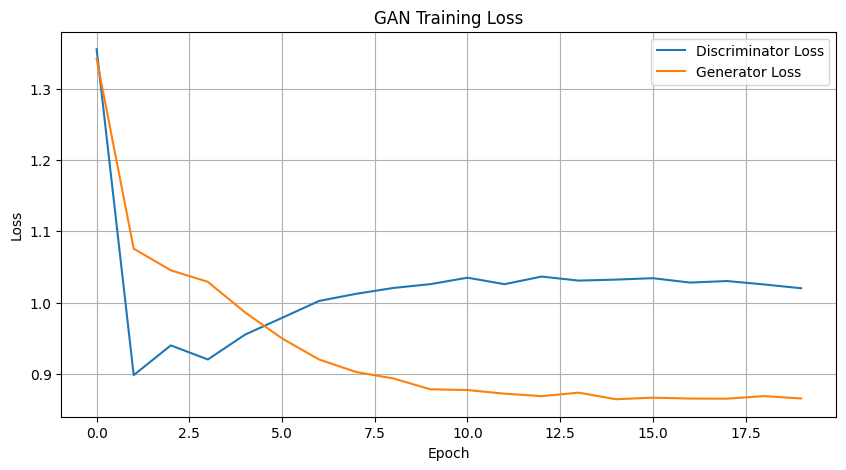

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(history['loss_d'], label='Discriminator Loss')
plt.plot(history['loss_g'], label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Loss')
plt.legend()
plt.grid(True)
plt.show()

# Generate Samples

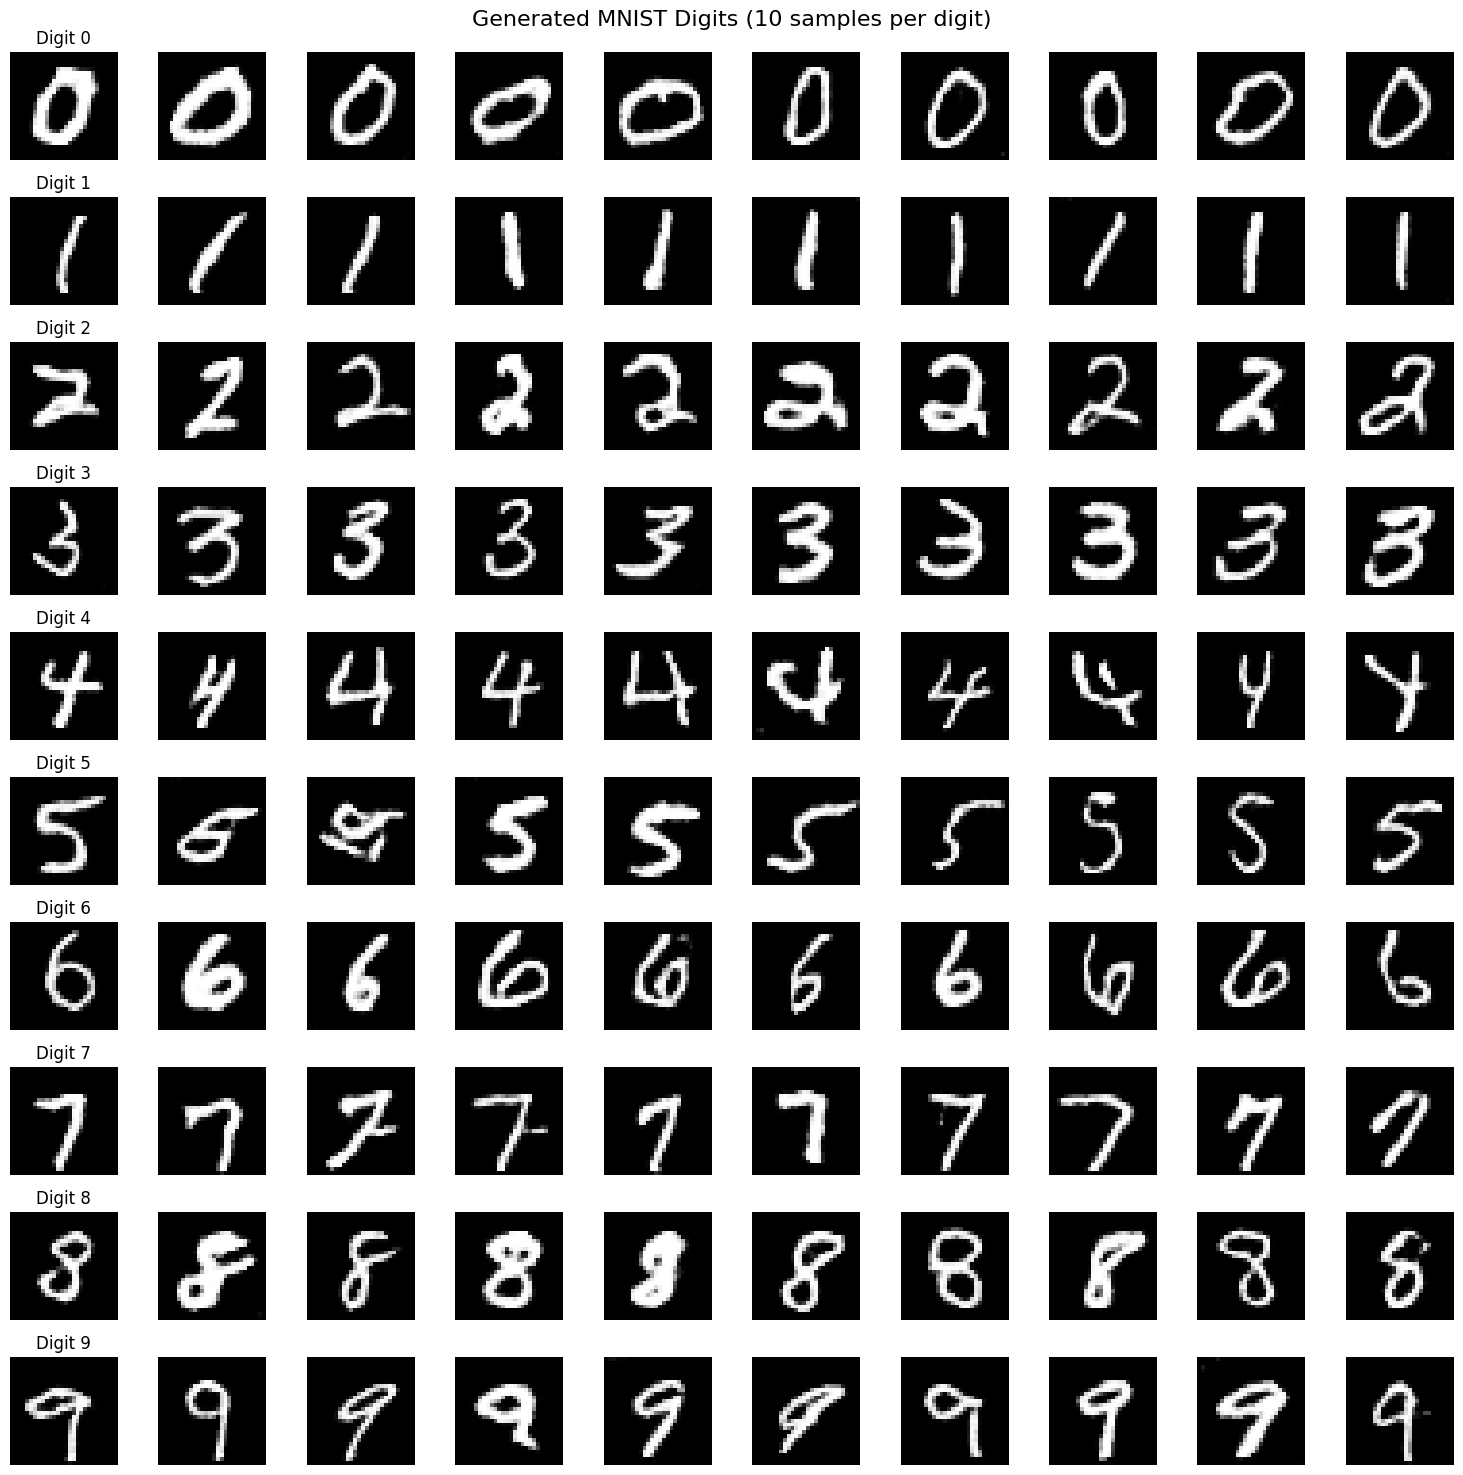

In [8]:
# Generate samples for each digit (0-9)
G.eval()
with torch.no_grad():
    # Generate 10 samples per digit
    n_samples_per_class = 10
    z = torch.randn(n_samples_per_class * 10, z_dim, device=device)
    y = torch.arange(10, device=device).repeat_interleave(n_samples_per_class)
    
    x_gen = G(z, y)
    x_gen = x_gen.cpu()

# Visualize generated images
fig, axes = plt.subplots(10, 10, figsize=(15, 15))
for i in range(10):  # Each digit
    for j in range(10):  # 10 samples per digit
        idx = i * n_samples_per_class + j
        img = x_gen[idx].squeeze().numpy()
        # Denormalize from [-1, 1] to [0, 1]
        img = (img + 1) / 2
        axes[i, j].imshow(img, cmap='gray')
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(f'Digit {i}', fontsize=12)

plt.suptitle('Generated MNIST Digits (10 samples per digit)', fontsize=16)
plt.tight_layout()
plt.show()

# Compare with Real Samples

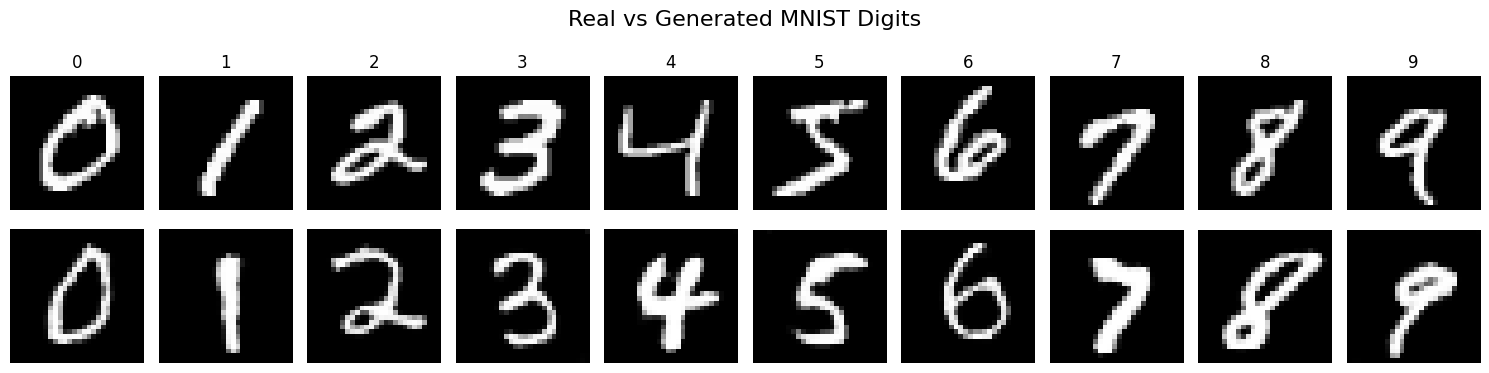

In [9]:
# Compare generated vs real samples side by side
fig, axes = plt.subplots(2, 10, figsize=(15, 4))

# Get real samples
real_samples = []
for digit in range(10):
    # Find first occurrence of each digit
    for x, y in train_dataset:
        if y == digit:
            real_samples.append(x)
            break

# Generate fake samples (one per digit)
with torch.no_grad():
    z = torch.randn(10, z_dim, device=device)
    y = torch.arange(10, device=device)
    fake_samples = G(z, y).cpu()

# Plot comparison
for i in range(10):
    # Real samples (top row)
    img_real = real_samples[i].squeeze().numpy()
    img_real = (img_real + 1) / 2  # Denormalize
    axes[0, i].imshow(img_real, cmap='gray')
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('Real', fontsize=14)
    axes[0, i].set_title(f'{i}', fontsize=12)
    
    # Fake samples (bottom row)
    img_fake = fake_samples[i].squeeze().numpy()
    img_fake = (img_fake + 1) / 2  # Denormalize
    axes[1, i].imshow(img_fake, cmap='gray')
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('Generated', fontsize=14)

plt.suptitle('Real vs Generated MNIST Digits', fontsize=16)
plt.tight_layout()
plt.show()